# Natural Language Processing - Exercise 2 (Problem 17)

## Authors
* Charteros Eleftherios ([l.harteros@gmail.com](mailto:l.harteros@gmail.com))
* Kotitsas Sotirios ([sotiriskot9@gmail.com](mailto:sotiriskot9@gmail.com))
* Stavropoulos Petros ([pstav1993@gmail.com](mailto:pstav1993@gmail.com))
* Xenouleas Efstratios ([stratosxen@gmail.com](mailto:stratosxen@gmail.com))

# Load Libraries and Dataset

In [ ]:
# Install latests tqdm
!pip install --upgrade tqdm

Requirement already up-to-date: tqdm in /usr/local/lib/python3.6/dist-packages (4.43.0)


In [ ]:
# Import everything
import pandas as pd
import numpy as np
import re
import nltk
import pdb
import sklearn
import gensim.downloader as api

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier
from sklearn.decomposition import TruncatedSVD, SparsePCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_recall_fscore_support,classification_report,precision_recall_curve,plot_precision_recall_curve,roc_auc_score
from matplotlib import pyplot as plt
from tqdm import tqdm,tqdm_pandas
from copy import deepcopy
import random
import sys

tqdm.pandas(file=sys.stdout)

nltk.download('punkt')
nltk.download('wordnet')
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# 1. Go to https://www.kaggle.com/c/twitter-sentiment-analysis2/data
# 1.a. Join the competition
# 1.b. Accept the terms in order to be able to download the data
# 2. Go to 'My account' on kaggle and press 'Create Api token'. 
# A file named 'kaggle.json' should be downloaded.
# Colab library to upload files. Upload 'kaggle.json'
# If it crashes either re-run it or download the train.csv data
# from the link above and upload it to colab (same directory as sample data)
from google.colab import files
files.upload()

# The kaggle.json config file needs to be located in /root/.kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

# Downlaod data for the twitter-sentiment-analysis Challenge
!kaggle competitions download -c twitter-sentiment-analysis2

# Unzip the downloaded data
!unzip train.csv.zip 

Saving kaggle.json to kaggle (8).json
test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  train.csv.zip
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


# Data Preprocessing



## Preprocess data 

In [ ]:
def preprocess(x, embedding=False):

    # Make text lower case
    x = x.lower()
    
    # Remove tags of other people
    x = re.sub(r"@\w*", " ", x)

    # remove special characters
    x = re.sub(r"#|^\*|\*$|&quot;|&gt;|&lt;|&lt;3", " ", x)
    x = x.replace("&amp;", " and ")

    # remove links
    x = re.sub(r"ht+p+s?://\S*", " ", x)   

    # remove non-ascii
    x = re.sub(r"[^\x00-\x7F]", " ", x)

    # #remove time 
    x = re.sub(r"((a|p).?m)?\s?(\d+(:|.)?\d+)\s?((a|p).?m)?", " ", x)

    # remove brackets if left after removing time
    x = re.sub(r"\(\)|\[\]|\{\}", " ", x)

    # for words we want to keep at least two occurences of 
    # each word(e.g not change good to god)
    x = re.sub(r"([a-z])\1+", r"\1\1", x)

    # for special characters we want to keep only one occurence
    x = re.sub(r"([\?\-\.\\/!:~;_\[\]\{\}\(\)])\1+", r"\1", x)

    #emojis
    x = re.sub(
        r"([\(\[\{\*][\-\^'._]?[:;x]|[:;][\-\^'._]?[pd3\)\]\}\*]|\s[x][\-\^'._]?[abdeop3\)\]\}]\s|<3|[\(]?\^[\-\^'._]?\^[\)]?)",
        " happyemoji ", x)
    x = re.sub(
        r"([:;][\-\^'._]?[o0\(\[\{\\/\|\$]|[x][\-\^'._]?[x\(\[\}\|\\/\$]|[o0][\-\^'._][o0\(\[\}\|\\/\$]|[t][\-\^'._][t\(\[\}\|\\/\$]|[>~][\-\^'._]?[<~])",
        " sademoji ", x)

    # remove any string that starts with number
    x = re.sub(r"\d[\w]*", " ", x)

    # remove all special characters left that were not classified as emoji
    x = re.sub(r"[^a-zA-Z0-9 ]", "", x)

    # remove single letters that left 
    x = re.sub(r"\s[b-z]\s", " ", x)

    # Remove multiple space chars
    x = " ".join(x.split())

    if not embedding:
        stemmer = PorterStemmer()
        x = " ".join([stemmer.stem(token) for token in x.split()])

    return x

In [ ]:
data = pd.read_csv("train.csv", encoding="ISO-8859-1")

# preprocess text
print("Preprocessing dataset ...\n")
data.SentimentText = data.SentimentText.progress_apply(lambda x: preprocess(x))

Preprocessing dataset ...

100%|██████████| 99989/99989 [00:24<00:00, 4108.94it/s]


## Split data to train dev test sets
 

In [ ]:
# Method that splits the data into train-dev-test
# (we create the dev-test from train.csv so that we have the correct labels for the metrics)
def train_val_test_split(data, split=0.8):
    train_size = int(len(data) * split)
    test_size = train_size + int((len(data) - train_size) / 2)

    train = data[:train_size]
    val = data[train_size:test_size]
    test = data[test_size:]

    return train, val, test

In [ ]:
# split to train, validation and test sets
print("\nSplitting dataset ...\n")
dataset = train_val_test_split(data)


Splitting dataset ...



## Create vocab from train set 

In [ ]:
# Creates the vocab using the words that appear up to 10 times and 
# are not stopwords or single characters
def find_popular_words(train_set):
    words = word_tokenize(train_set.SentimentText.str.cat())
    freq = nltk.FreqDist(words)
    vocab = set()
    
    vocab.update(
        [word for word in tqdm(words) if (freq[word] >= 10) and
         (word not in stopwords.words("english") and
          (len(word) > 1))])
    
    return vocab

In [ ]:
# get vocab with frequent words
print("Creating vocab from train set ...\n")
vocab = find_popular_words(dataset[0])

Creating vocab from train set ...



100%|██████████| 845449/845449 [01:09<00:00, 12085.19it/s]


## Replace words not in the vocab with the unk token 

In [ ]:
def map_unknown_words(x, vocab):
    x = [x if x in vocab else 'unk' for x in x.split()]
    x = " ".join(x)
    return x


def clean_dataset(dataset, vocab):
    cleaned_dataset = []
    for data in dataset:
        data.SentimentText = data.SentimentText.progress_apply(lambda x: map_unknown_words(x, vocab))
        cleaned_dataset.append(data[data.SentimentText != ""])

    return cleaned_dataset

In [ ]:
print("\nCleaning dataset based on vocab ...\n")

# Remove words not in vocab and empty tweets from dataset
clean_dataset = clean_dataset(dataset, vocab)
train_set, val_set, test_set = clean_dataset

# Concat the train and validation data to create the tune set
tune_set=pd.concat([train_set,val_set])


Cleaning dataset based on vocab ...

100%|██████████| 9999/9999 [00:00<00:00, 235106.94it/s]


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


# Data Classification 

## Create TF-IDF features from the words in the train dev and test sets

In [ ]:
# Create the vectorizer
vectorizer = TfidfVectorizer()

# Vectorize train
x_train, y_train = vectorizer.fit_transform(train_set.SentimentText), train_set.Sentiment

# Vectorize the tune set (This will be used on 'tune_classifier' method 
# below which performs cross validation)
x_tune, y_tune = vectorizer.transform(tune_set.SentimentText), tune_set.Sentiment

# Vectorize the validation and test sets
x_val, y_val = vectorizer.transform(val_set.SentimentText), val_set.Sentiment
x_test, y_test = vectorizer.transform(test_set.SentimentText), test_set.Sentiment


## Optional : Use SVD dimensionality reduction

In [ ]:
use_svd = True

if use_svd:
    svd = TruncatedSVD(n_components=1000, random_state=44)
    # Perform dimensionality reduction using SVD
    x_train = svd.fit_transform(x_train)
    x_val, x_test = svd.transform(x_val), svd.transform(x_test)
    x_tune = svd.transform(x_tune)


## Define classifiers

In [ ]:
# Gather all the classifiers into one list
def define_classifiers(use_svd):

    classifiers = []

    classifiers.append(DummyClassifier(strategy="most_frequent"))
    classifiers.append(LogisticRegression(max_iter=200,random_state=44))

    if use_svd:
        classifiers.append(GaussianNB())

    classifiers.append(MLPClassifier(early_stopping=True,random_state=44))

    return classifiers


In [ ]:
classifiers=define_classifiers(use_svd)

## Train classifiers

In [ ]:
def train_classifier(x_train, y_train,x_val, y_val, classifier, verbose=0):
        
    classifier.fit(x_train, y_train)
    if verbose==1:
        print('\n===================== {} =====================\n'.format(type(classifier).__name__))

        print('Train score: {}'.format(classifier.score(x_train, y_train)))

        print('Val score: {}'.format(classifier.score(x_val, y_val)))

def train_classifiers(x_train, y_train,x_val, y_val, classifiers, verbose=0):

    for classifier in classifiers:
        train_classifier(x_train, y_train,x_val, y_val, classifier, verbose)

def test_classifiers( x_test, y_test, classifiers):
    for classifier in classifiers:
        print('\n===================== {} =====================\n'.format(type(classifier).__name__))

        print('Test score: {}'.format(classifier.score(x_test, y_test)))

In [ ]:
# Train Results of Classifiers
print('Train - Dev Results of Classifers')
train_classifiers(x_train, y_train, x_val, y_val, classifiers,verbose=1)

Train - Dev Results of Classifers

===================== DummyClassifier =====================

Train score: 0.5578064791454858
Val score: 0.5851181498240322

===================== LogisticRegression =====================

Train score: 0.7521557404827353
Val score: 0.747209653092006

===================== GaussianNB =====================

Train score: 0.6493830879491911
Val score: 0.6489693313222725

===================== MLPClassifier =====================

Train score: 0.7864718655470623
Val score: 0.7537456008044243


## Tune best classifiers

In [ ]:
def tune_classifier(estimator, parameter_grid, x_tune, y_tune, train_indices, val_indices):
    # Perform a 5-fold (default) cross validation

    if estimator == 'logistic':
        cls = GridSearchCV(LogisticRegression(max_iter=200, random_state=44, penalty='l2'), parameter_grid, cv=zip([train_indices],[val_indices]),verbose=1)
    else:
        cls = GridSearchCV(MLPClassifier(early_stopping=True, random_state=44), parameter_grid, cv=zip([train_indices],[val_indices]),verbose=1)
    
    print('Tuning {} classifier'.format(estimator))
    cls.fit(x_tune, y_tune)

    return cls.best_estimator_, cls.best_params_



In [ ]:
# Separate train and val indicies in order to distinguish the 
# samples on the tune set which are used below on 'tune_classifier' method
train_indices = list(range(len(train_set)))
num_val=len(tune_set)
val_indices = list(range(num_val))
val_indices = val_indices[len(train_set):]
train_indices, val_indices = np.asarray(train_indices), np.asarray(val_indices)

# Define the parameter space
param_grid_lr = {'C': [0.001, 0.005, 0.01, 0.1, 1.0, 1.5, 2.0]}
param_grid_mlp = {'solver': ['adam','sgd'], 'alpha': [0.0001, 0.001],'learning_rate_init' : [0.001, 0.0001] }

# Tune the classifiers and store the results
results = [tune_classifier('logistic', param_grid_lr, x_tune, y_tune, train_indices, val_indices), 
           tune_classifier('mlp', param_grid_mlp, x_tune, y_tune, train_indices, val_indices)]

# Append the best classifiers
for result in results:
    classifiers.append(result[0])



Tuning logistic classifier
Fitting 1 folds for each of 7 candidates, totalling 7 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   45.6s finished


Tuning mlp classifier
Fitting 1 folds for each of 8 candidates, totalling 8 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 14.6min finished


## Test classifiers

In [ ]:
# Test Results of Classifiers
test_classifiers(x_test, y_test,classifiers)


===================== DummyClassifier =====================

Test score: 0.5995570767062613

===================== LogisticRegression =====================

Test score: 0.7433058184014496

===================== GaussianNB =====================

Test score: 0.6589490638212201

===================== MLPClassifier =====================

Test score: 0.7490436883430642

===================== LogisticRegression =====================

Test score: 0.7454197704852024

===================== MLPClassifier =====================

Test score: 0.7454197704852024


# Classifier Metrics 


## Bullet 1,2 : Precision,Recall,F1 by class and macro averaged

* Precision, Recall, F1 scores for each class 
* Macro - Precision, Macro - Recall, Macro - F1 scores



In [ ]:
def prf(y_pred, y_true, classes):
    """
    This method takes as input the predictions of y, the true y values and a list of all the classes eg. [0, 1, 2]
    """
    # Initialize zero lists with the shape of the classes
    true_positives = [0]*len(classes)
    false_positives = [0]*len(classes)
    false_negatives = [0]*len(classes)
    recalls = [0]*len(classes)
    precisions = [0]*len(classes)
    f1s = [0]*len(classes)

    # Find the TP, FP and FN for each class
    for i, c in enumerate(classes):
        true_positives[i] = sum([1 for e, e2 in zip(y_pred, y_true) if e == e2 == c])
        false_positives[i] = sum([1 for e, e2 in zip(y_pred, y_true) if e == c and e2 != c])
        false_negatives[i] = sum([1 for e, e2 in zip(y_pred, y_true) if e != c and e2 == c])
    
    # Calculate the recall, precision and f1 of each class
    for i in range(len(classes)):
        if true_positives[i] + false_negatives[i] == 0:
            recalls[i] = 0.0
        else:
            recalls[i] = true_positives[i] / (true_positives[i] + false_negatives[i])
        if true_positives[i] + false_positives[i] == 0:
            precisions[i] = 0.0
        else:
            precisions[i] = true_positives[i] / (true_positives[i] + false_positives[i])
        if recalls[i] + precisions[i] == 0:
            f1s[i] = 0.0
        else:
            f1s[i] = 2*recalls[i]*precisions[i] / (recalls[i] + precisions[i])

    return recalls, precisions, f1s

In [ ]:
def report_prf(x_train,y_train,x_val,y_val,x_test,y_test,classifiers,classes=[0, 1]):

    def pretty_print(pred,y,classes):
        recalls, precisions, f1s = prf(pred, y, classes)
        print("\t\t\tPrecision \t Recall \t F1")
        for category in classes:
            print("Class {} (negative)\t {:.4f} \t {:.4f} \t {:.4f}".format(category,precisions[category],recalls[category],f1s[category]))
                
        macro_precision = np.mean(precisions)
        macro_recall = np.mean(recalls)
        macro_f1 = np.mean(f1s)
        print("Macro - Average\t\t {:.4f} \t {:.4f} \t {:.4f}".format(macro_precision,macro_recall,macro_f1))

    for classifier in classifiers:
        pred_train=classifier.predict(x_train)
        pred_val=classifier.predict(x_val)
        pred_test=classifier.predict(x_test)

        print('===================== {} ====================='.format(type(classifier).__name__))
        print()
        print("Train Set")
        pretty_print(pred_train,y_train,classes)
        print("**********************************************************")
        print("Validation Set")
        pretty_print(pred_val,y_val,classes)
        print("**********************************************************")
        print("Test Set")
        pretty_print(pred_test,y_test,classes)
        print()

In [ ]:
report_prf(x_train,y_train,x_val,y_val,x_test,y_test,classifiers)

===================== DummyClassifier =====================

Train Set
			Precision 	 Recall 	 F1
Class 0 (negative)	 0.0000 	 0.0000 	 0.0000
Class 1 (negative)	 1.0000 	 0.5578 	 0.7161
Macro - Average		 0.5000 	 0.2789 	 0.3581
**********************************************************
Validation Set
			Precision 	 Recall 	 F1
Class 0 (negative)	 0.0000 	 0.0000 	 0.0000
Class 1 (negative)	 1.0000 	 0.5851 	 0.7383
Macro - Average		 0.5000 	 0.2926 	 0.3691
**********************************************************
Test Set
			Precision 	 Recall 	 F1
Class 0 (negative)	 0.0000 	 0.0000 	 0.0000
Class 1 (negative)	 1.0000 	 0.5996 	 0.7497
Macro - Average		 0.5000 	 0.2998 	 0.3748

===================== LogisticRegression =====================

Train Set
			Precision 	 Recall 	 F1
Class 0 (negative)	 0.6535 	 0.7533 	 0.6999
Class 1 (negative)	 0.8304 	 0.7514 	 0.7889
Macro - Average		 0.7419 	 0.7524 	 0.7444
**********************************************************
Validation Se

## Bullet 3 : Statistical Significance

*   Statistical Significance on Macro - Average F1 for best classifier



In [ ]:
# Method that returns the f1 score of predictions
def getScore(y_pred, y_true, classes=[0, 1]):
        _, _, f1s = prf(y_pred, y_true, classes)
        macro_f1 = np.mean(f1s)
        return macro_f1

# Method that performs significance test, in order to confirm that the predictions
#  of our best model are statistical significant 
def significance_test(x, y,classifiers,best_classifier, num_tests=1000):

    # Create a test dataloader
    for i in range(len(classifiers)):
        
        if i!=best_classifier:

            # Get the predictions of the best classifier (using the index given in the arguments)
            predsA = classifiers[best_classifier].predict(x)
            # Get the predictions of the other classifier
            predsB = classifiers[i].predict(x)

            # Calculate their scores
            scoreA = getScore(predsA, y)
            scoreB = getScore(predsB, y)

            # Calculate the difference of their scores
            orig_diff = scoreA - scoreB

            # Initialize a counter
            num_invalid = 0

            # Perform a number of tests given
            for n in tqdm(range(num_tests),file=sys.stdout):
                # Copy the original predictions
                temp_predsA = deepcopy(predsA)
                temp_predsB = deepcopy(predsB)
                # Swap with probability 1/2 some of the predictions of the 
                #  two models
                for j in range(len(y)):
                    rval = random.random()
                    if rval < 0.5:
                        temp = temp_predsA[j]
                        temp_predsA[j] = temp_predsB[j]
                        temp_predsB[j] = temp

                # Calculate the new scores
                new_sysA_metric = getScore(temp_predsA, y)
                new_sysB_metric = getScore(temp_predsB, y)

                # Calculate the new difference
                new_diff = new_sysA_metric - new_sysB_metric

                # If the new difference is bigger than the original, then by swapping some of the predictions
                #  of our best model with the worst one, then the worst model helped the predictions, which
                #  would indicate that the difference is not statistical significant in this test, or the
                #  hypothesis was "invalid"
                if new_diff >= orig_diff:
                    num_invalid += 1
                    
            # Print how many "invalid" hypothesis from all the tets
            print()
            print('===================== {} vs {} ====================='.format(type(classifiers[best_classifier]).__name__,type(classifiers[i]).__name__))
            print(float(num_invalid + 1) / float(num_tests + 1))
            print()

In [ ]:
significance_test(x_test,y_test,classifiers,best_classifier=5,num_tests=1000)

100%|██████████| 1000/1000 [00:52<00:00, 19.16it/s]

===================== MLPClassifier vs DummyClassifier =====================
0.000999000999000999

100%|██████████| 1000/1000 [00:54<00:00, 18.50it/s]

===================== MLPClassifier vs LogisticRegression =====================
0.025974025974025976

100%|██████████| 1000/1000 [00:54<00:00, 18.47it/s]

===================== MLPClassifier vs GaussianNB =====================
0.000999000999000999

100%|██████████| 1000/1000 [00:54<00:00, 18.24it/s]

===================== MLPClassifier vs MLPClassifier =====================
0.27972027972027974

100%|██████████| 1000/1000 [00:54<00:00, 18.48it/s]

===================== MLPClassifier vs LogisticRegression =====================
0.08391608391608392



## Bullet 4 : F1 learning curve

* Learning curve for macro-averaged F1 on train and dev sets for different sizes of data

In [ ]:
def f1_curve(x_train,y_train,x_val,y_val,classifiers, step=0.1):
      
    # For each classifier, we plot the f1 curve
    for classifier in classifiers:

        step_x_ticks, macro_f1s_train, macro_f1s_val = list(), list(), list()

        for i in tqdm(range(0, x_train.shape[0], int(step*x_train.shape[0]))):
            x_train_sample = x_train[:int(i+step*x_train.shape[0])]
            y_train_sample = y_train[:int(i+step*x_train.shape[0])]

            train_classifier(x_train_sample,y_train_sample,x_val,y_val,classifier)

            step_x_ticks.append(x_train_sample.shape[0])

            macro_f1s_train.append(getScore(classifier.predict(x_train_sample), y_train_sample))
            macro_f1s_val.append(getScore(classifier.predict(x_val), y_val))

        plt.plot(step_x_ticks, macro_f1s_train, 'b-o', label='Train')
        plt.plot(step_x_ticks, macro_f1s_val, 'r-o', label='Val')
        plt.xticks(step_x_ticks)
        plt.ylim([0.0, 1.0])
        plt.title(type(classifier).__name__)
        plt.legend()
        plt.show()

100%|██████████| 11/11 [00:01<00:00,  6.89it/s]


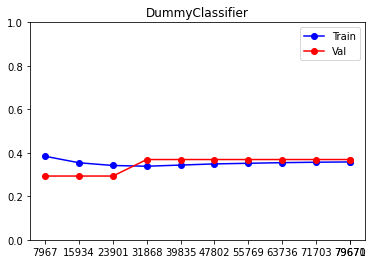

100%|██████████| 11/11 [00:52<00:00,  4.81s/it]


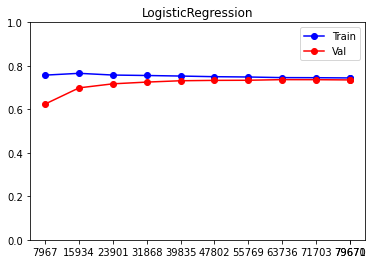

100%|██████████| 11/11 [00:16<00:00,  1.54s/it]


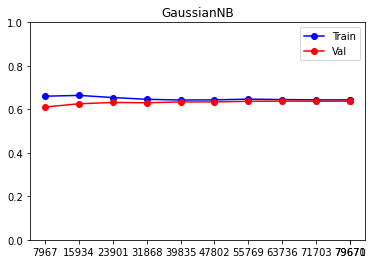

100%|██████████| 11/11 [07:00<00:00, 38.24s/it]


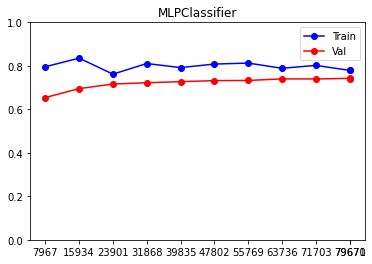

100%|██████████| 11/11 [01:00<00:00,  5.46s/it]


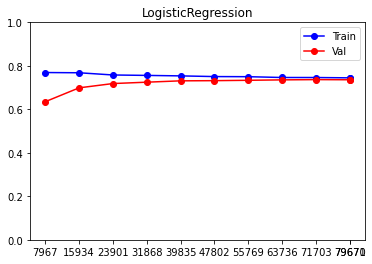

100%|██████████| 11/11 [06:46<00:00, 36.95s/it]


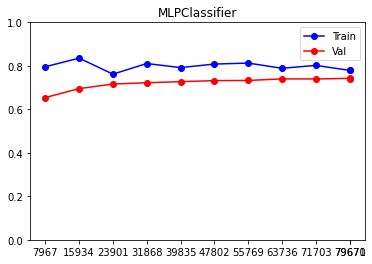

In [ ]:
f1_curve(x_train,y_train,x_val,y_val,classifiers)

## Bullet 5 : Macro - Precision Recall curve and AUC score

* Macro Averaged Precision Recall curve based on test set as well as AUC score 

       DummyClassifier - AUC Score 0.5000 


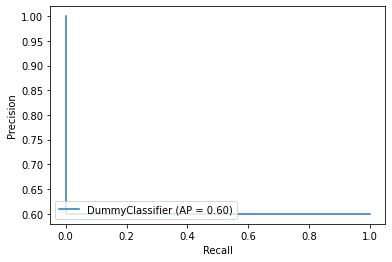

       LogisticRegression - AUC Score 0.7237 


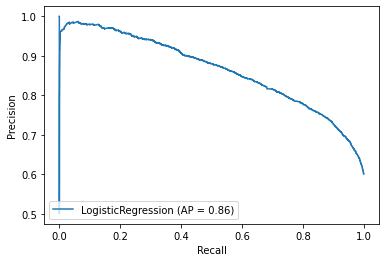

       GaussianNB - AUC Score 0.6450 


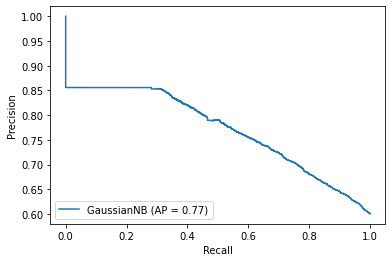

       MLPClassifier - AUC Score 0.7277 


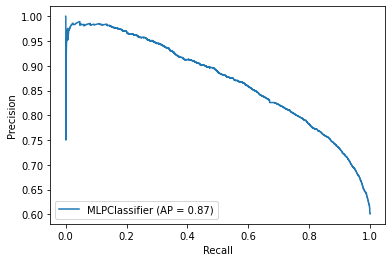

       LogisticRegression - AUC Score 0.7240 


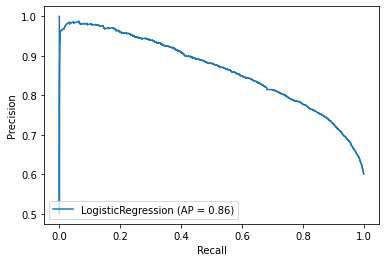

       MLPClassifier - AUC Score 0.7277 


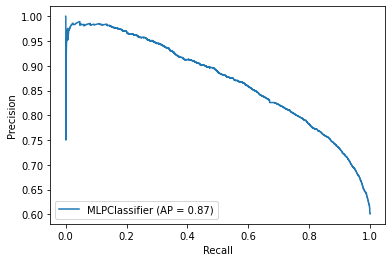

In [ ]:
for classifier in classifiers:
    print('       {} - AUC Score {:.4f} '.format(type(classifier).__name__,roc_auc_score(y_test, classifier.predict(x_test))))

    plot_precision_recall_curve(classifier, x_test, y_test,response_method="predict_proba")
    plt.show()

# Optional Code (Centroids instead of TF-IDF features)


*   The code is the same as above for clarity of the process as it follows the order of the pdf (all the functions see the tabs on the left)
*   The only difference in the code is on the 2nd section (Data Classification) where centroid features are created from the vocab 



## Alternative Data Preprocessing : Centroids of word embeddings



In [ ]:
# See https://github.com/RaRe-Technologies/gensim-data for more choices
model = api.load("glove-twitter-100")

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


### Preprocess data 

In [ ]:
def preprocess(x, embedding=False):

    # make text lower case
    x = x.lower()

    # remove tags of other people
    x = re.sub(r"@\w*", " ", x)

    # remove special characters
    x = re.sub(r"#|^\*|\*$|&quot;|&gt;|&lt;|&lt;3", " ", x)
    x = x.replace("&amp;", " and ")

    # remove links
    x = re.sub(r"ht+p+s?://\S*", " ", x)

    # remove non-ascii
    x = re.sub(r"[^\x00-\x7F]", " ", x)

    # #remove time 
    x = re.sub(r"((a|p).?m)?\s?(\d+(:|.)?\d+)\s?((a|p).?m)?", " ", x)

    # remove brackets if left after removing time
    x = re.sub(r"\(\)|\[\]|\{\}", " ", x)

    # for words we want to keep at least two occurences of 
    # each word(e.g not change good to god)
    x = re.sub(r"([a-z])\1+", r"\1\1", x)

    # for special characters we want to keep only one occurence
    x = re.sub(r"([\?\-\.\\/!:~;_\[\]\{\}\(\)])\1+", r"\1", x)

    # #emojis
    x = re.sub(
        r"([\(\[\{\*][\-\^'._]?[:;x]|[:;][\-\^'._]?[pd3\)\]\}\*]|\s[x][\-\^'._]?[abdeop3\)\]\}]\s|<3|[\(]?\^[\-\^'._]?\^[\)]?)",
        " happyemoji ", x)
    x = re.sub(
        r"([:;][\-\^'._]?[o0\(\[\{\\/\|\$]|[x][\-\^'._]?[x\(\[\}\|\\/\$]|[o0][\-\^'._][o0\(\[\}\|\\/\$]|[t][\-\^'._][t\(\[\}\|\\/\$]|[>~][\-\^'._]?[<~])",
        " sademoji ", x)

    # remove any string that starts with number
    x = re.sub(r"\d[\w]*", " ", x)

    # remove all special characters left that were not classified as emoji
    x = re.sub(r"[^a-zA-Z0-9 ]", "", x)
    # remove single letters that left 
    x = re.sub(r"\s[b-z]\s", " ", x)

    x = " ".join(x.split())

    if not embedding:
        stemmer = PorterStemmer()
        x = " ".join([stemmer.stem(token) for token in x.split()])

    return x

In [ ]:
data = pd.read_csv("train.csv", encoding="ISO-8859-1")

# preprocess text
print("Preprocessing dataset ...\n")
data.SentimentText = data.SentimentText.progress_apply(lambda x: preprocess(x,embedding=True))

Preprocessing dataset ...

100%|██████████| 99989/99989 [00:04<00:00, 20560.16it/s]


### Split data to train dev test sets
 

In [ ]:
# Method that splits the data into train-dev-test
# (we create the dev-test from train.csv so that we have the correct labels for the metrics)
def train_val_test_split(data, split=0.8):
    train_size = int(len(data) * split)
    test_size = train_size + int((len(data) - train_size) / 2)

    train = data[:train_size]
    val = data[train_size:test_size]
    test = data[test_size:]

    return train, val, test

In [ ]:
# split to train, validation and test sets
print("\nSplitting dataset ...\n")
dataset = train_val_test_split(data)


Splitting dataset ...



### Create vocab from train set 

In [ ]:
# Creates the vocab using the words that appear up to 10 times and 
# are not stopwords or single characters
def find_popular_words(train_set):
    words = word_tokenize(train_set.SentimentText.str.cat())
    freq = nltk.FreqDist(words)
    vocab = set()
    
    vocab.update(
        [word for word in tqdm(words) if (freq[word] >= 10) and
         (word not in stopwords.words("english") and
          (len(word) > 1))])
    
    return vocab

In [ ]:
# get vocab with frequent words
print("Creating vocab from train set ...\n")
vocab = find_popular_words(dataset[0])

Creating vocab from train set ...



100%|██████████| 845487/845487 [01:08<00:00, 12348.41it/s]


### Replace words not in the vocab with the unk token 

In [ ]:
def map_unknown_words(x, vocab):
    x = [x if x in vocab else 'unk' for x in x.split()]
    x = " ".join(x)
    return x


def clean_dataset(dataset, vocab):
    cleaned_dataset = []
    for data in dataset:
        data.SentimentText = data.SentimentText.progress_apply(lambda x: map_unknown_words(x, vocab))
        cleaned_dataset.append(data[data.SentimentText != ""])

    return cleaned_dataset

In [ ]:
print("\nCleaning dataset based on vocab ...\n")

# Remove words not in vocab and empty cells from dataset
clean_dataset = clean_dataset(dataset, vocab)
train_set, val_set, test_set = clean_dataset

# Concat the train and validation data
tune_set=pd.concat([train_set,val_set])


Cleaning dataset based on vocab ...

100%|██████████| 9999/9999 [00:00<00:00, 243427.15it/s]


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


## Alternative Data Classification : Centroids of word embeddings


### Create Centoid features from the words in the train dev and test sets

In [ ]:
def get_centroid(tweets, idf):
    """
    Calculates the centroid of a tweet

    Args:
      tweets(pd.series()): The preprocessed tweets with stopwords removed
      ids(dict): With keys the word of the vocab and values its IDF
    """

    # Initialize the array where the vectors will be stored
    centroids = np.zeros((len(tweets), model.vector_size))

    # For each tweet
    for i, tweet in enumerate(tweets):

        # Tokenize the tweet
        tokenized_tweet = word_tokenize(tweet)

        # Calculate the frequencies of each term in the tweet
        tf = {word: tweet.count(word) for word in tokenized_tweet}

        # The denoinator which is used for the normalization of the vectors
        div = 0

        # Computing the centroid
        for word in tf:
            if word in idf and word in model:
                p = tf[word] * idf[word]
                # centroid = np.add(centroid, model[word]*p)
                centroids[i, :] += model[word] * p
                div += p

        # If the denominator not equal to zero, normalizr...
        if div != 0:
            centroids[i, :] = np.divide(centroids[i, :], div)

    return centroids

In [ ]:
vectorizer_for_centroids = TfidfVectorizer()

# Calculates the the inverse document frequencies using the train set
vectorizer_for_centroids.fit(train_set.SentimentText)
idf = {word: vectorizer_for_centroids.idf_[i] for i, word in enumerate(vectorizer_for_centroids.get_feature_names()) }

# Get the centroidss for the train set
x_train, y_train = get_centroid(train_set.SentimentText, idf), train_set.Sentiment

# Get the centroidss for the tune set
x_tune, y_tune = get_centroid(tune_set.SentimentText, idf), tune_set.Sentiment

# Get the centroidss for the validation and test sets
x_val, y_val = get_centroid(val_set.SentimentText, idf), val_set.Sentiment
x_test, y_test = get_centroid(test_set.SentimentText, idf), test_set.Sentiment

### Define classifiers

In [ ]:
# Gather all the classifiers into one list
def define_classifiers(use_svd):

    classifiers = []

    classifiers.append(DummyClassifier(strategy="most_frequent"))
    classifiers.append(LogisticRegression(max_iter=200,random_state=44))

    if use_svd:
        classifiers.append(GaussianNB())

    classifiers.append(MLPClassifier(early_stopping=True,random_state=44))

    return classifiers


In [ ]:
use_svd=False
classifiers=define_classifiers(use_svd)

### Train classifiers

In [ ]:
def train_classifier(x_train, y_train,x_val, y_val, classifier, verbose=0):
        
    classifier.fit(x_train, y_train)
    if verbose==1:
        print('\n===================== {} =====================\n'.format(type(classifier).__name__))

        print('Train score: {}'.format(classifier.score(x_train, y_train)))

        print('Val score: {}'.format(classifier.score(x_val, y_val)))

def train_classifiers(x_train, y_train,x_val, y_val, classifiers, verbose=0):

    for classifier in classifiers:
        train_classifier(x_train, y_train,x_val, y_val, classifier, verbose)

def test_classifiers( x_test, y_test, classifiers):
    for classifier in classifiers:
        print('\n===================== {} =====================\n'.format(type(classifier).__name__))

        print('Test score: {}'.format(classifier.score(x_test, y_test)))

In [ ]:
# Train Results of Classifiers
print('Train - Dev Results of Classifers')
train_classifiers(x_train, y_train, x_val, y_val, classifiers,verbose=1)

Train - Dev Results of Classifers

===================== DummyClassifier =====================

Train score: 0.5578064791454858
Val score: 0.5851181498240322

===================== LogisticRegression =====================

Train score: 0.7158941145460708
Val score: 0.7200603318250377

===================== MLPClassifier =====================

Train score: 0.7463568927213164
Val score: 0.7358471593765712


### Tune best classifiers

In [ ]:
def tune_classifier(estimator, parameter_grid, x_tune, y_tune, train_indices, val_indices):
    # Perform a 5-fold cross validation

    if estimator == 'logistic':
        cls = GridSearchCV(LogisticRegression(max_iter=200, random_state=44, penalty='l2'), parameter_grid, cv=zip([train_indices],[val_indices]),verbose=1)
    else:
        cls = GridSearchCV(MLPClassifier(early_stopping=True, random_state=44), parameter_grid, cv=zip([train_indices],[val_indices]),verbose=1)
    
    print('Tuning {} classifier'.format(estimator))
    cls.fit(x_tune, y_tune)

    return cls.best_estimator_, cls.best_params_



In [ ]:
# Separate train and val indicies in order to distinguish the 
# samples on the tune set which are used below on 'tune_classifier' method
train_indices = list(range(len(train_set)))
num_val=len(tune_set)
val_indices=list(range(num_val))
val_indices = val_indices[len(train_set):]
train_indices, val_indices = np.asarray(train_indices), np.asarray(val_indices)

# Define the parameter space
param_grid_lr = {'C': [0.001, 0.005, 0.01, 0.1, 1.0, 1.5, 2.0]}
param_grid_mlp = {'solver': ['adam','sgd'], 'alpha': [0.0001, 0.001],'learning_rate_init' : [0.001, 0.0001] }

# Tune the classifiers and store the results
results = [tune_classifier('logistic', param_grid_lr, x_tune, y_tune, train_indices, val_indices), 
           tune_classifier('mlp', param_grid_mlp, x_tune, y_tune, train_indices, val_indices)]

# Append the best classifiers
for result in results:
    classifiers.append(result[0])



### Test classifiers

In [ ]:
# Test Results of Classifiers
test_classifiers(x_test, y_test,classifiers)


===================== DummyClassifier =====================

Test score: 0.5995570767062613

===================== LogisticRegression =====================

Test score: 0.7138111536138514

===================== MLPClassifier =====================

Test score: 0.7352526676062009


## Alternative Classifier Metrics : Centroids of word embeddings


### Bullet 1,2 : Precision,Recall,F1 by class and macro averaged

* Precision, Recall, F1 scores for each class 
* Macro - Precision, Macro - Recall, Macro - F1 scores



In [ ]:
def prf(y_pred, y_true, classes):
    """
    This method takes as input the predictions of y, the true y values and a list of all the classes eg. [0, 1, 2]
    """
    # Initialize zero lists with the shape of the classes
    true_positives = [0]*len(classes)
    false_positives = [0]*len(classes)
    false_negatives = [0]*len(classes)
    recalls = [0]*len(classes)
    precisions = [0]*len(classes)
    f1s = [0]*len(classes)

    # Find the TP, FP and FN for each class
    for i, c in enumerate(classes):
        true_positives[i] = sum([1 for e, e2 in zip(y_pred, y_true) if e == e2 == c])
        false_positives[i] = sum([1 for e, e2 in zip(y_pred, y_true) if e == c and e2 != c])
        false_negatives[i] = sum([1 for e, e2 in zip(y_pred, y_true) if e != c and e2 == c])
    
    # Calculate the recall, precision and f1 of each class
    for i in range(len(classes)):
        if true_positives[i] + false_negatives[i] == 0:
            recalls[i] = 0.0
        else:
            recalls[i] = true_positives[i] / (true_positives[i] + false_negatives[i])
        if true_positives[i] + false_positives[i] == 0:
            precisions[i] = 0.0
        else:
            precisions[i] = true_positives[i] / (true_positives[i] + false_positives[i])
        if recalls[i] + precisions[i] == 0:
            f1s[i] = 0.0
        else:
            f1s[i] = 2*recalls[i]*precisions[i] / (recalls[i] + precisions[i])

    return recalls, precisions, f1s

In [ ]:
def report_prf(x_train,y_train,x_val,y_val,x_test,y_test,classifiers,classes=[0, 1]):

    def pretty_print(pred,y,classes):
        precisions, recalls, f1s = prf(pred, y, classes)
        print("\t\t\tPrecision \t Recall \t F1")
        for category in classes:
            print("Class {} (negative)\t {:.4f} \t {:.4f} \t {:.4f}".format(category,precisions[category],recalls[category],f1s[category]))
                
        macro_precision = np.mean(precisions)
        macro_recall = np.mean(recalls)
        macro_f1 = np.mean(f1s)
        print("Macro - Average\t\t {:.4f} \t {:.4f} \t {:.4f}".format(macro_precision,macro_recall,macro_f1))

    for classifier in classifiers:
        pred_train=classifier.predict(x_train)
        pred_val=classifier.predict(x_val)
        pred_test=classifier.predict(x_test)

        print('===================== {} ====================='.format(type(classifier).__name__))
        print()
        print("Train Set")
        pretty_print(pred_train,y_train,classes)
        print("**********************************************************")
        print("Validation Set")
        pretty_print(pred_val,y_val,classes)
        print("**********************************************************")
        print("Test Set")
        pretty_print(pred_test,y_test,classes)
        print()

In [ ]:
report_prf(x_train,y_train,x_val,y_val,x_test,y_test,classifiers)

===================== DummyClassifier =====================

Train Set
			Precision 	 Recall 	 F1
Class 0 (negative)	 0.0000 	 0.0000 	 0.0000
Class 1 (negative)	 1.0000 	 0.5578 	 0.7161
Macro - Average		 0.5000 	 0.2789 	 0.3581
**********************************************************
Validation Set
			Precision 	 Recall 	 F1
Class 0 (negative)	 0.0000 	 0.0000 	 0.0000
Class 1 (negative)	 1.0000 	 0.5851 	 0.7383
Macro - Average		 0.5000 	 0.2926 	 0.3691
**********************************************************
Test Set
			Precision 	 Recall 	 F1
Class 0 (negative)	 0.0000 	 0.0000 	 0.0000
Class 1 (negative)	 1.0000 	 0.5996 	 0.7497
Macro - Average		 0.5000 	 0.2998 	 0.3748

===================== LogisticRegression =====================

Train Set
			Precision 	 Recall 	 F1
Class 0 (negative)	 0.6251 	 0.7002 	 0.6605
Class 1 (negative)	 0.7879 	 0.7261 	 0.7557
Macro - Average		 0.7065 	 0.7132 	 0.7081
**********************************************************
Validation Se

### Bullet 3 : Statistical Significance

*   Statistical Significance on Macro - Average F1 for best classifier



In [ ]:
# Method that returns the f1 score of predictions
def getScore(y_pred, y_true, classes=[0, 1]):
        _, _, f1s = prf(y_pred, y_true, classes)
        macro_f1 = np.mean(f1s)
        return macro_f1

# Method that performs significance test, in order to confirm that the predictions
#  of our best model are statistical significant 
def significance_test(x, y,classifiers,best_classifier, num_tests=1000):

    # Create a test dataloader
    for i in range(len(classifiers)):

        if i!=best_classifier:

            # Get the predictions of the best classifier (using the index given in the arguments)
            predsA = classifiers[best_classifier].predict(x)
            # Get the predictions of the other classifier
            predsB = classifiers[i].predict(x)

            # Calculate their scores
            scoreA = getScore(predsA, y)
            scoreB = getScore(predsB, y)

            # Calculate the difference of their scores
            orig_diff = scoreA - scoreB

            # Initialize a counter
            num_invalid = 0

            # Perform a number of tests given
            for n in tqdm(range(num_tests),file=sys.stdout):
                # Copy the original predictions
                temp_predsA = deepcopy(predsA)
                temp_predsB = deepcopy(predsB)
                # Swap with probability 1/2 some of the predictions of the 
                #  two models
                for j in range(len(y)):
                    rval = random.random()
                    if rval < 0.5:
                        temp = temp_predsA[j]
                        temp_predsA[j] = temp_predsB[j]
                        temp_predsB[j] = temp

                # Calculate the new scores
                new_sysA_metric = getScore(temp_predsA, y)
                new_sysB_metric = getScore(temp_predsB, y)

                # Calculate the new difference
                new_diff = new_sysA_metric - new_sysB_metric

                # If the new difference is bigger than the original, then by swapping some of the predictions
                #  of our best model with the worst one, then the worst model helped the predictions, which
                #  would indicate that the difference is not statistical significant in this test, or the
                #  hypothesis was "invalid"
                if new_diff >= orig_diff:
                    num_invalid += 1
                    
            # Print how many "invalid" hypothesis from all the tets
            print()
            print('===================== {} vs {} ====================='.format(type(classifiers[best_classifier]).__name__,type(classifiers[i]).__name__))
            print(float(num_invalid + 1) / float(num_tests + 1))
            print()

In [ ]:
significance_test(x_test,y_test,classifiers,best_classifier=2,num_tests=1000)

100%|██████████| 1000/1000 [00:51<00:00, 19.40it/s]

===================== MLPClassifier vs DummyClassifier =====================
0.000999000999000999

100%|██████████| 1000/1000 [00:52<00:00, 19.12it/s]

===================== MLPClassifier vs LogisticRegression =====================
0.000999000999000999



### Bullet 4 : F1 learning curve

* Learning curve for macro-averaged F1 on train and dev sets for different sizes of data

In [ ]:
def f1_curve(x_train,y_train,x_val,y_val,classifiers, step=0.1):
    
    # For each classifier, we plot the f1 curve
    for classifier in classifiers:

        step_x_ticks, macro_f1s_train, macro_f1s_val = list(), list(), list()

        for i in tqdm(range(0, x_train.shape[0], int(step*x_train.shape[0]))):
            x_train_sample = x_train[:int(i+step*x_train.shape[0])]
            y_train_sample = y_train[:int(i+step*x_train.shape[0])]

            train_classifier(x_train_sample,y_train_sample,x_val,y_val,classifier)

            step_x_ticks.append(x_train_sample.shape[0])

            macro_f1s_train.append(getScore(classifier.predict(x_train_sample), y_train_sample))
            macro_f1s_val.append(getScore(classifier.predict(x_val), y_val))

        plt.plot(step_x_ticks, macro_f1s_train, 'b-o', label='Train')
        plt.plot(step_x_ticks, macro_f1s_val, 'r-o', label='Val')
        plt.xticks(step_x_ticks)
        plt.ylim([0.0, 1.0])
        plt.title(type(classifier).__name__)
        plt.legend()
        plt.show()

100%|██████████| 11/11 [00:01<00:00,  7.40it/s]


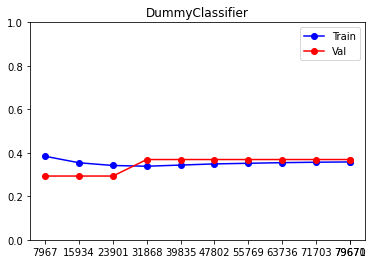

100%|██████████| 11/11 [00:16<00:00,  1.48s/it]


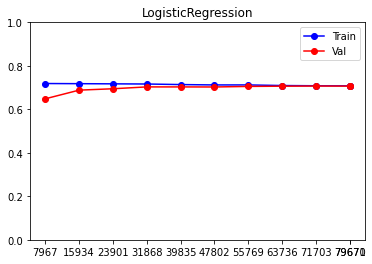

100%|██████████| 11/11 [01:53<00:00, 10.32s/it]


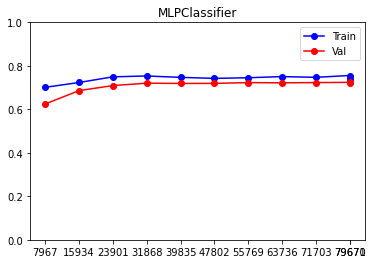

In [ ]:
f1_curve(x_train,y_train,x_val,y_val,classifiers)

### Bullet 5 : Macro - Precision Recall curve and AUC score

* Macro Averaged Precision Recall curve based on test set as well as AUC score 

       DummyClassifier - AUC Score 0.5000 


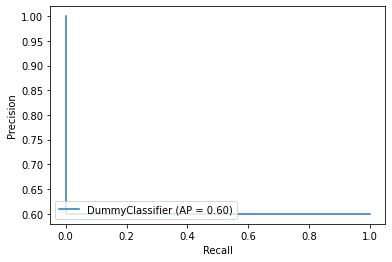

       LogisticRegression - AUC Score 0.6953 


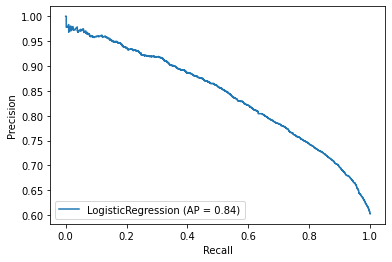

       MLPClassifier - AUC Score 0.7136 


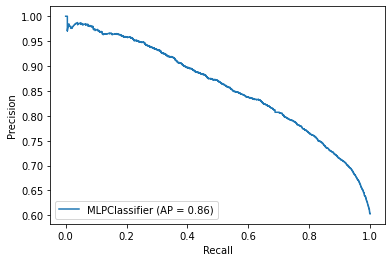

In [ ]:
for classifier in classifiers:
    print('       {} - AUC Score {:.4f} '.format(type(classifier).__name__,roc_auc_score(y_test, classifier.predict(x_test))))

    plot_precision_recall_curve(classifier, x_test, y_test,response_method="predict_proba")
    plt.show()